In [1]:
import sys

sys.path.insert(1,'../')

In [2]:
import numpy as np
import random
from numpy.linalg.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from scipy.optimize import minimize, approx_fprime
from sklearn.preprocessing import StandardScaler
from Trees.hw_tree import Tree,get_candidate_columns_default
from Kernels.hw_kernels import RBF,KernelizedRidgeRegression

In [3]:


def normalize(x):
    def nf(f):
        temp = np.max(f)-np.min(f)
        nf = (f - np.min(f))/(temp)
        return nf
    return np.apply_along_axis(func1d=nf, axis=0, arr=x)

In [4]:
def tt_split(data, size, rnd=False):
    test_size = round(len(data)*(1-size))
    test_set = data[-test_size:]
    train_set = data[:-test_size]
    return train_set, test_set


class Layer:
    """Layer object with weights and biases"""

    def __init__(self, shape, activation_f, w=None, b=None):
        self.shape = shape
        self.w = self.init_w_b(self.shape) if w is None else w
        self.b = self.init_w_b((1, self.shape[1])) if b is None else b
        self.activation_f = activation_f
        self.a = None
        self.z = None
        # Local gradient
        self.dw = None
        self.db = None
        self.delta = None
        self.prev_idx = None

    def init_w_b(self, _shape):
        return np.random.uniform(-1, 1, size=_shape)
        # return np.ones(shape=_shape)

    def activate(self, x):
        """Activation of the layer."""
        self.z = np.dot(x, self.w) + self.b
        self.a = self.activation_f(self.z)
        return self.a

    def set_args(self, arr):
        """Setting attributes in different, matrix shape."""
        idx = self.shape[0]*self.shape[1]
        self.w = arr[:idx].reshape(self.shape)
        self.b = arr[idx:]

    def prev_layer(self, x):
        self.prev_idx = x

In [5]:


class ANN(ABC):
    def __init__(self, _lambda=0.01, units=[], lr=1, _iter=100, seed=0):
        np.random.seed(seed)
        self.units = units
        self.layers = []
        self._lambda = _lambda
        self.lr = lr
        self._iter = _iter
        self.loss_val = []
        super().__init__()

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def softmax(z):
        res = np.sum(np.exp(z), axis=1)
        return np.exp(z)/(res.reshape((z.shape[0], 1)))

    @staticmethod
    def derivative_sigmoid(z):
        return z * (1 - z)

    @abstractmethod
    def activation_f(self, z):
        pass

    @abstractmethod
    def last_activation_f(self, z):
        pass

    @abstractmethod
    def activation_fprim(self, z):
        pass

    @abstractmethod
    def loss_f(self, yhat, y):
        pass

    @abstractmethod
    def loss_fprim(self, yhat, y):
        pass

    @abstractmethod
    def out_layer_size(self):
        pass

    def cost(self, _x=None, _y=None):
        x = self.x
        y = self.y
        if(isinstance(_x, np.ndarray) and _x.any()):
            x = _x
        if(isinstance(_x, np.ndarray) and _y.any()):
            y = _y
        cost = np.sum([self.loss_f(self.feedforward(x), y)])
        cost_args = [np.square(l.w) for l in self.layers]
        cost_args = np.sum([np.sum(x) for x in cost_args])
        return cost + (cost_args * self._lambda)/x.shape[0]

    def change_args(self, args):
        idx = 0
        for i, l in enumerate(self.layers):
            idx += l.shape[1] + l.shape[0]*l.shape[1]
            if(l.prev_idx):
                l.set_args(args[l.prev_idx:idx])
            elif(i < len(self.layers)-1):
                self.layers[i+1].prev_layer(idx)
                l.set_args(args[:idx])

    def get_args(self):
        w = []
        for l in self.layers:
            res = np.hstack([np.ravel(l.w), np.ravel(l.b)])
            w.append(res)
        return np.concatenate(w)

    def init_layers(self):
        # Add input and output layer specs in unit list
        num_layers = len(self.units)
        if(num_layers):
            for i in range(num_layers+1):
                shape = ()
                if(i == 0):
                    shape = (self.x.shape[1], self.units[i])
                    self.layers.append(
                        Layer(shape=shape, activation_f=self.activation_f))

                elif(i == num_layers):
                    shape = (self.units[i-1], self.out_layer_size())
                    self.layers.append(
                        Layer(shape=shape, activation_f=self.last_activation_f))
                else:
                    shape = (self.units[i-1], self.units[i])
                    self.layers.append(
                        Layer(shape=shape, activation_f=self.activation_f))
        else:
            self.layers.append(
                Layer(shape=(self.x.shape[1], self.out_layer_size()), activation_f=self.last_activation_f))

    def optimize(self):
        return minimize(fun=self.opt_feedforward, x0=self.get_args(
        ), jac=self.backpropagation, method='BFGS', options={'maxiter': self._iter, 'disp': True})

    def fit(self, x, y):
        self.x = x
        self.y = y
        if isinstance(self, ANNClassification):
            self.transform_y()
        self.init_layers()
        self.change_args(self.optimize().x)
        return self

    def feedforward(self, x):
        """Loop through layers and finally calculate output"""
        res = x
        for l in self.layers:
            res = l.activate(res)
        # Activation result of last layer
        return res

    def opt_feedforward(self, args):
        self.change_args(args)
        res = self.cost()
        self.loss_val.append(res)
        return res

    def backpropagation(self, args):
        self.change_args(args)
        no_l = len(self.layers)
        g = np.array([])
        w = None
        delta = None
        for i, l in enumerate(reversed(self.layers)):
            if i == (no_l-1):
                prev_l = self.x
            else:
                prev_l = list(reversed(self.layers))[i+1].a

            if i == 0:

                l.delta = l.a - \
                    self.y.reshape(self.y.shape[0], self.out_layer_size())
                l.dw = np.dot(prev_l.T, l.delta) / \
                    self.x.shape[0] + (2*self._lambda/self.x.shape[0])*l.w
                l.db = np.mean(l.delta, axis=0)
            else:
                l.delta = np.dot(delta, w.T)*l.a*(1-l.a)
                l.db = np.mean(l.delta, axis=0)
                l.dw = np.dot(prev_l.T, l.delta) / \
                    self.x.shape[0] + (2*self._lambda/self.x.shape[0])*l.w
            w = l.w
            delta = l.delta
            g = np.concatenate((np.concatenate(
                (np.ravel(l.dw), np.ravel(l.db))), g))
        return g

    def predict(self, x):
        return self.feedforward(x).reshape((x.shape[0], self.out_layer_size()))

In [6]:


class ANNRegression(ANN):
    def activation_f(self, z):
        return ANN.sigmoid(z)

    def activation_fprim(self, z):
        return ANN.derivative_sigmoid(z)

    def loss_f(self, yhat, y):
        res = (np.mean((np.ravel(yhat) - np.ravel(y))**2))/2
        return res

    def loss_fprim(self, yhat, y):
        return (y - yhat)

    def out_layer_size(self):
        return 1

    def last_activation_f(self, z):
        return z


class ANNClassification(ANN):

    def activation_f(self, z):
        return ANN.sigmoid(z)

    def activation_fprim(self, z):
        return ANN.derivative_sigmoid(z)

    def loss_f(self, yhat, y):
        e = 1e-8
        res = np.nan_to_num(-y*np.log(yhat + e))
        return np.sum(res)/y.shape[0]

    def loss_fprim(self, yhat, y):
        return 0

    def out_layer_size(self):
        return self.y.shape[1]

    def last_activation_f(self, z):
        return ANN.softmax(z)

    def get_prediction(self, x):
        res = self.predict(x)
        return np.apply_along_axis(lambda it: np.argmax(it), arr=res, axis=1)

    def transform_y(self):
        y = np.zeros(shape=(self.y.shape[0], np.unique(self.y).shape[0]))
        try:
            print(0)
            for i, val in enumerate(self.y):
                y[i][int(val)] = 1
            self.y = y
        except print(0):
            pass


def check_grad(model: ANN, x, y):
    model.x = x
    model.y = y
    model.init_layers()
    if(isinstance(model, ANNClassification)):

        y = model.transform_y()

    args = model.get_args()

    def backpropagation():
        model.change_args(args)
        model.feedforward(x)
        res = model.backpropagation(args)
        return res

    def get_cost(_args, _model, _x, _y):
        _model.change_args(_args)
        return model.cost(_x, _y)

    approx_g = approx_fprime(args, get_cost,
                             1e-8, model, model.x, model.y)
    g = backpropagation()
    return 0


SEED = 123


def housing2r():
    data = np.genfromtxt('housing2r.csv', delimiter=',', skip_header=True)
    train, test = tt_split(data, 0.8)

    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test = test[:, :-1], test[:, -1]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X=X_train)
    X_test = scaler.transform(X_test)
    # X_train = normalize(X_train)
    # X_test = normalize(X_test)
    model = ANNRegression(_lambda=0.0001, units=[
                          16], _iter=500, seed=SEED).fit(X_train, y_train)
    clf = KernelizedRidgeRegression(
        0.0005, kernel=RBF(sigma=0.2)).fit(X_train, y_train)
    print('MSE (ANNRegression):', model.loss_f(model.predict(X_test), y_test))
    print('MSE (KernelizedRidgeRegression):',
          model.loss_f(clf.predict(X_test), y_test))
    xlabels = list(range(len(test)))
    for x, ymin, ymax in zip(xlabels, model.predict(
            X_test), y_test):
        plt.vlines(x, ymin, ymax, color='red', alpha=0.4)
    for x, ymin, ymax in zip(xlabels, clf.predict(
            X_test), y_test):
        plt.vlines(x, ymin, ymax, color='red', alpha=0.4)
    plt.scatter(xlabels, model.predict(
        X_test), color='blue', label='ANNRegression', alpha=0.65)
    plt.scatter(xlabels, y_test, color='green', label='True', alpha=0.65)
    plt.scatter(xlabels, clf.predict(X_test),
                color='orange', label='SVR', alpha=0.65)
    plt.xlabel('Samples')
    plt.ylabel('y')
    plt.title('Predicted and true values on housing2r using ANNRegression')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig('predtrue2r.png')
    plt.show()
    plt.clf()
    plt.plot(list(range(len(model.loss_val))), model.loss_val)
    plt.title('Cost function - ANN Regression')
    plt.grid()
    plt.xlabel('Number of evaluations')
    plt.ylabel('Cost value')
    plt.tight_layout()
    plt.savefig('cost2r.png')
    plt.show()
    plt.clf()


def housing3r():
    data = pd.read_csv('housing3.csv', delimiter=',')
    data["Class"] = data.Class.astype('category').cat.codes
    train, test = tt_split(data.to_numpy(), 0.8)
    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test = test[:, :-1], test[:, -1]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X=X_train)
    X_test = scaler.transform(X_test)
    # X_train = normalize(X_train)
    # X_test = normalize(X_test)
    model = ANNClassification(_lambda=0.02, units=[
        16], _iter=300, seed=SEED).fit(X_train, y_train)
    clf = Tree(random.Random(SEED), get_candidate_columns_default, 20)
    clf.build(X_train, y_train)
    clf.predict_proba(X_test)
    model.y = y_test
    model.transform_y()
    print('CrossEntropy(ANNClassification):',
          model.loss_f(model.predict(X_test), model.y))
    print('CrossEntropy (ClassificationTree):',
          model.loss_f(clf.predict_proba(X_test), model.y))
    plt.plot(list(range(len(model.loss_val))), model.loss_val)
    plt.title('Cost function - ANN Classification')
    plt.grid()
    plt.xlabel('Number of evaluations')
    plt.ylabel('Cost value')
    plt.tight_layout()
    plt.savefig('cost3r.png')
    plt.show()
    plt.clf()


def create_final_predictions():
    data = pd.read_csv('train.csv', index_col=0)
    data["target"] = data.target.astype('category').cat.codes
    data = data.to_numpy()
    test = pd.read_csv('test.csv', index_col=0).to_numpy()
    np.random.shuffle(data)
    X, y = data[:, :-1], data[:, -1]

    scaler = StandardScaler()
    X = scaler.fit_transform(X=X)
    test = scaler.transform(test)

    model = ANNClassification(_lambda=0.0001, units=[10, 10], _iter=50)
    print(np.unique(y, return_counts=True))
    model.fit(X, y)
    print(model.loss_f(model.predict(X), model.y))
    print('Accuracy:', np.sum(np.apply_along_axis(lambda x: np.argmax(x),
                                                  axis=1, arr=model.predict(X)) == y)/model.y.shape[0])
    p = model.predict(test)
    dataframe = pd.DataFrame(data=p, index=range(1, len(p)+1), columns=[
                             'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9'])
    dataframe.index.name = 'id'
    with open('final_prob.txt', 'w') as f:
        dataframe.to_csv(f, header=True, index=True)
    pred = np.apply_along_axis(lambda x: np.argmax(x), axis=1, arr=p)
    np.savetxt('final.txt', pred, delimiter=',')
    return

         Current function value: 1.309974
         Iterations: 500
         Function evaluations: 516
         Gradient evaluations: 516
MSE (ANNRegression): 84.43089468442318
MSE (KernelizedRidgeRegression): 172.2909797907575


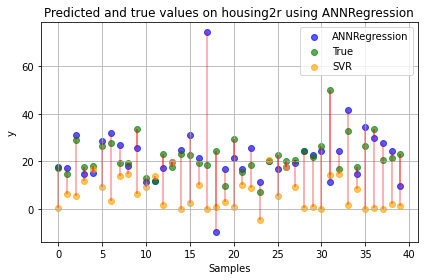

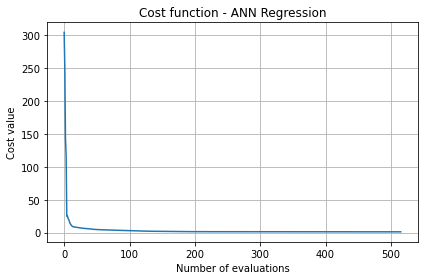

0
         Current function value: 0.051722
         Iterations: 300
         Function evaluations: 301
         Gradient evaluations: 301
0
CrossEntropy(ANNClassification): 0.49278688139163246
CrossEntropy (ClassificationTree): 0.501921546361928


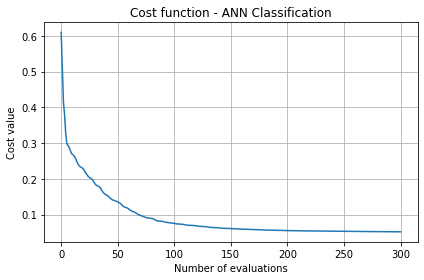

<Figure size 432x288 with 0 Axes>

In [7]:
if __name__ == '__main__':
    housing2r()
    housing3r()
    # create_final_predictions()